# Machine Learning: Programming Exercise 3

## Multi-class Classification and Neural Networks
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classication task. In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

### 1.1 Dataset

You are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits*. The .mat format means that that the data has been saved in a native MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program's memory. The matrix will already be named, so you do not need to assign names to them. 
*This is a subset of the MNIST handwritten digit dataset
Run the code below to load the data.

In [3]:
# start by loading the data
import scipy.io as sio

data = sio.loadmat("ex3data1.mat")
X = data["X"]
y = data["y"].ravel()
# y = y.reshape(len(y))

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in
# MATLAB where there is no index 0
y[y == 10] = 0

m, n = X.shape

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$
X = \begin{bmatrix} -(x^{(1)})^T - \newline
    -(x^{(2)})^T - \newline
    \vdots \newline
    -(x^{(m)})^T - 
    \end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a '0' digit is labeled as '10', while the digits '1' to '9' are labeled as '1' to '9' in their natural order.


### 1.2 Visualizing the data

You will begin by visualizing a subset of the training set. The code below randomly selects selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. We have provided the displayData function, and you are encouraged to examine the code to see how it works. After you run this step, you should see an image like Figure 1.

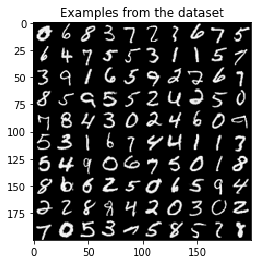

In [4]:
import random
from PIL import Image

# get 100 random images from the dataset
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# loop over the images, turn them into a PIL image
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)
                                                     ).transpose()  # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

### 1.3 Vectorizing logistic regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

#### 1.3.1 Vectorizing the cost function

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$
J(\theta) =\frac{1}{m}\sum_{i=1}^m \left[-y^{(i)} \log(h_{\theta}(x^{(i)}))- (1-y^{(i)}) \log(1- h_{\theta}(x^{(i)}))\right],
$$

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every example $i$, where $h_{\theta}(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) =\frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as

$$
X\theta = \begin{bmatrix} -(x^{(1)})^T\theta - \newline
    -(x^{(2)})^T\theta - \newline
    \vdots \newline
    -(x^{(m)})^T\theta - 
    \end{bmatrix}
    = \begin{bmatrix} -\theta^T(x^{(1)}) - \newline
    -\theta^T(x^{(2)}) - \newline
    \vdots \newline
    -\theta^T(x^{(m)}) - 
    \end{bmatrix}
$$

In the last equality, we used the fact that $a^T b= b^T a$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

Your job is to write the unregularized cost function in the file `lrCostFunction` Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops. (Hint: You might want to use the element-wise multiplication operation (.*) and the sum operation sum when writing this function).

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the th element is defined as

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}
$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,

$$
\left[ \begin{array}{c} 
\frac{\partial J(\theta)}{\partial \theta_0} \\
\frac{\partial J(\theta)}{\partial \theta_1} \\
\frac{\partial J(\theta)}{\partial \theta_2} \\
\vdots \\
\frac{\partial J(\theta)}{\partial \theta_n}   
 \end{array} \right]
 = \frac{1}{m}
\left[ \begin{array}{c} 
\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x_0^{(i)} \\
\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x_1^{(i)} \\
\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x_2^{(i)} \\
\vdots \\
\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x_n^{(i)}
\end{array}\right] =\frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)}\right)x^{(i)} =
\frac{1}{m}X^T \left( h_\theta(x)-y\right) \\
(1)
$$

where

$$
h_\theta(x) -y = \begin{bmatrix} h_\theta(x^{(1)}) - y^{(1)} \newline
    h_\theta(x^{(2)}) - y^{(2)} \newline
    \vdots \newline
    h_\theta(x^{(m)}) - y^{(m)} 
    \end{bmatrix}
$$

Note that $x^{(i)}$ is a vector, while $(h_\theta(x^{(i)})-y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = (h_\theta(x^{(i)})-y^{(i)})$ and observe that:

$$
\sum_i \beta_i x^{(i)} = \begin{bmatrix} & \vert & \vert & \vert \\
    & x^{(1)} & x^{(2)} \cdots & x^{(m)} \\
    & \vert & \vert & \vert
    \end{bmatrix} \begin{bmatrix} \beta_1 \newline \beta_2 \newline \vdots \newline \beta_m \end{bmatrix} = X^T\beta,
$$

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement Equation (1) to compute the correct vectorized gradient. Once you are done, complete the function `lrCostFunction` by implementing the gradient.

**Debugging Tip:** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the size function. For example, given a data matrix $X$ of size 100 x 20 (100 examples, 20 features) and $\theta$, a vector with dimensions 20 x 1, you can observe that $X\theta$ is a valid multiplication operation, while $\theta X$ is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.

### 1.3.3 Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as

$$
J(\theta) =\frac{1}{m}\sum_{i=1}^m\left[-y^{(i)} \log(h_{\theta}(x^{(i)}))- (1 -y^{(i)}) \log(1-h_{\theta}(x^{(i)}))\right]+\frac{\lambda}{2m}\sum_{j=1}^n{\theta_j^2}
$$

Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^m\left( h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}\qquad \mathrm{for}\;j=0, \\
\frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m}\sum_{i=1}^m\left( h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)} \right)+\frac{\lambda}{m}\theta_j\qquad \mathrm{for}\;j\geq1
$$

Now modify your code in `lrCostFunction` to account for regularization. Once again, you should not put any loops into your code. When you are finished, run the code below to test your vectorized implementation and compare to expected outputs:

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def lrCostFunction(theta, X, y, lambda_):
    m = len(y)
    if y.dtype == bool:
      y = y.astype(int)

    h = sigmoid(X @ theta)
    reg = (lambda_ / (2 * m)) * (theta[1:].T @ theta[1:])
    J = 1/m * (-y.T @ np.log(h) - (1-y).T @ np.log(1-h)) + reg

    grad_reg = (lambda_ / m) * theta
    grad_reg[0] = 0
    grad = 1/m * X.T @ (h - y.reshape(m)) + grad_reg

    return J, grad

In [6]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(
    1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# test value for the regularization parameter
lambda_t = 3

J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]')


Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


**Tip:** When implementing the vectorization for regularized logistic regression, you might often want to only sum and update certain elements of $\theta$. In MATLAB, you can index into the matrices to access and update only certain elements. For example, A(:,3:5)= B(:, 1:3) will replace columns 3 to 5 of A with the columns 1 to 3 from B. One special keyword you can use in indexing is the end keyword in indexing. This allows us to select columns (or rows) until the end of the matrix. For example, A(:, 2:end) will only return elements from the 2nd to last column of A. Thus, you could use this together with the sum and .^ operations to compute the sum of only the elements you are interested in (e.g. sum(z(2:end).^2)). In the starter code, `lrCostFunction`, we have also provided hints on yet another possible method computing the regularized gradient.

### 1.4 One-vs-all classication

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset (Figure 1). In the handwritten digits dataset, $K=10$, but your code should work for any value of $K$.

You should now complete the code in `oneVsAll` to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K\times(N+1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a for loop from 1 to K, training each classifier independently.

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit '0' to the label 10 (to avoid confusions with indexing). When training the classifier for class $k \in \{1,\ldots,K\}$, you will want a $m$-dimensional vector of labels $y$, where $y_j\in \{0,\;1\}$ indicates whether the $j$-th training instance belongs to class $k\; (y_j = 1)$, or if it belongs to a different class $(y_j = 0)$. You may find logical arrays helpful for this task.

In [7]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(0, num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 400, "disp": False}
        res = minimize(lrCostFunction,
                        initial_theta,
                        (X, (y == c), lambda_),
                        jac=True,
                        method='CG',
                        options=options)
        all_theta[c, :] = res.x

    return all_theta


Furthermore, you will be using fmincg for this exercise (instead of fminunc). fmincg works similarly to fminunc, but is more more efficient for dealing with a large number of parameters. After you have correctly completed the code for `oneVsAll`, run the code below to use your `oneVsAll` function to train a multi-class classifier.

In [8]:
lambda_ = 0.1
num_labels = 10

all_theta = oneVsAll(X, y, num_labels, lambda_)


#### One-vs-all prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the 'probability' that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label $(1, 2,..., \text{ or } K)$ as the prediction for the input example.

You should now complete the code in `predictOneVsAll` to use the one-vs-all classifier to make predictions. Once you are done, run the code below to call your `predictOneVsAll` function using the learned value of $\Theta$. You should see that the training set  accuracy is about 94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).

In [9]:
def predictOneVsAll(all_theta, X):
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    g = sigmoid(X @ all_theta.T)
    return np.argmax(g, axis=1)

In [10]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))


Training Set Accuracy: 96.46%


## 2. Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classier. (You could add more features such as polynomial features to logistic regression, but that can be very expensive to train.) In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. 

For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week's exercise, you will write the backpropagation algorithm for learning the neural network parameters.

### 2.1 Model representation

Our neural network is shown in Figure 2. It has 3 layers- an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 x 20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in `ex3weights.mat` and are loaded into `Theta1` and `Theta2` by running the code below. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

### 2.2 Feedforward propagation and prediction

Now you will implement feedforward propagation for the neural network. You will need to complete the code in `predict` to return the neural network's prediction. You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classication strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$.

**Implementation Note:** The matrix X contains the examples in rows. When you complete the code in `predict`, you will need to add the column of 1's to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. In MATLAB, when you compute $z^{(2)} = \Theta^{(1)}a^{(1)}$, be sure that you index (and if necessary, transpose) X correctly so that you get $a^{(1)}$ as a column vector.

Once you are done, run the code below to call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

The code below will displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image. Rerun to repeat with another image.